<a href="https://colab.research.google.com/github/AhmedMemon-007/AhmedMemon-007/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [124]:
df_charging=pd.read_csv('/content/ev_charging_dataset.csv')
df_loc=pd.read_csv('/content/location_dataset.csv')

In [125]:
df_charging.shape

(64945, 28)

In [126]:
df_loc.shape

(31, 4)

In [127]:
df_charging.head(2)

,Date_Time,Vehicle_ID,Battery_Capacity_kWh,State_of_Charge_%,Energy_Consumption_Rate_kWh/km,Current_Latitude,Current_Longitude,Destination_Latitude,Destination_Longitude,Distance_to_Destination_km,...,Session_Start_Hour,Fleet_Size,Fleet_Schedule,Temperature_C,Wind_Speed_m/s,Precipitation_mm,Weekday,Charging_Preferences,Weather_Conditions,Charging_Load_kW
0,2017-01-01 00:00:00,106,66.746483,50.216524,0.153521,32.777266,-96.788301,32.784014,-96.795776,30.531144,...,6,10,0,13.954368,0.144765,0.712211,1,0,Cloudy,30.839677
1,2017-01-01 01:00:00,106,82.731496,59.358609,0.119101,32.779136,-96.786137,32.778406,-96.798310,1.004305,...,6,10,0,38.926466,0.461061,2.746260,3,0,Cloudy,47.354691


In [128]:
df_loc.head(2)

,S#,Location,Type,Coordinates
0,1,A,City,"(0, 0)"
1,2,B,Port,"(5, 10)"


In [129]:
df_charging.isnull().sum().sum()

np.int64(0)

In [130]:
df_loc.isnull().sum().sum()

np.int64(0)

In [131]:
#Preprocess location dataset (customer delivery points)
df_loc[['X', 'Y']] = df_loc['Coordinates'].str.extract(r'\((.*), (.*)\)').astype(float)

df_customers = df_loc[['S#', 'Location', 'Type', 'X', 'Y']]

In [132]:
# Group by unique station and average numeric values
df_charging_stations = df_charging.groupby('Charging_Station_ID').agg({
    'Charging_Rate_kW': 'mean',
    'Queue_Time_mins': 'mean',
    'Charging_Load_kW': 'mean',
    'Current_Latitude': 'first',
    'Current_Longitude': 'first'
}).reset_index()

In [133]:
# Select top 10 by charging rate
df_top_stations = df_charging_stations.sort_values(by='Charging_Rate_kW', ascending=False).head(10).reset_index(drop=True)

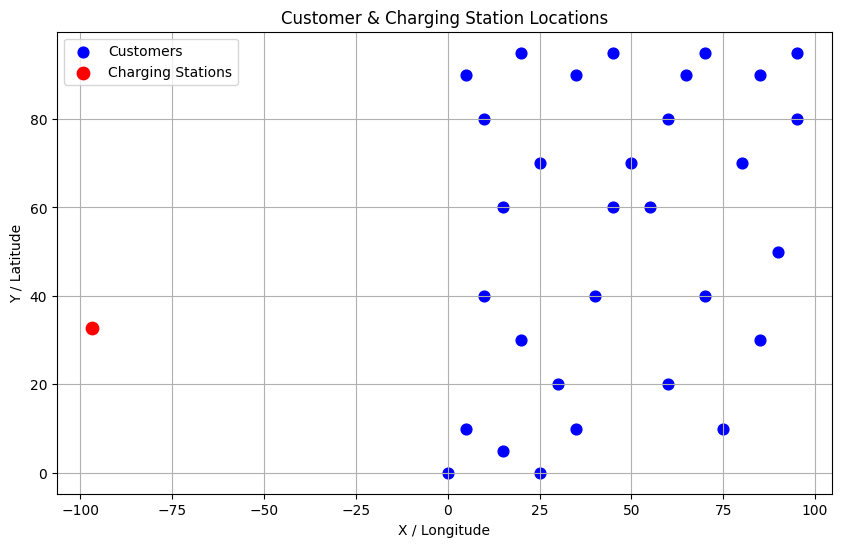

In [134]:
plt.figure(figsize=(10, 6))
plt.scatter(df_customers['X'], df_customers['Y'], c='blue', label='Customers', s=60)
plt.scatter(df_top_stations['Current_Longitude'], df_top_stations['Current_Latitude'], c='red', label='Charging Stations', s=80)
plt.xlabel('X / Longitude')
plt.ylabel('Y / Latitude')
plt.title('Customer & Charging Station Locations')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
from scipy.spatial.distance import cdist

# Combine customers and stations into one list of points
customer_coords = df_customers[['X', 'Y']].to_numpy()
station_coords = df_top_stations[['Current_Longitude', 'Current_Latitude']].to_numpy()

# Compute Euclidean distance matrices
dist_customer_customer = cdist(customer_coords, customer_coords, metric='euclidean')
dist_customer_station = cdist(customer_coords, station_coords, metric='euclidean')

In [136]:
battery_capacity_km = 100  # max distance without recharge
energy_consumption_per_km = 0.2  # % battery per km

In [137]:
# Mark customer-to-customer paths that exceed battery limit
infeasible_mask = dist_customer_customer > battery_capacity_km
#converting to binary mask or penalty values
penalty_matrix = np.where(infeasible_mask, 9999, dist_customer_customer)

In [138]:
#Percentage of infeasible paths
total_paths = dist_customer_customer.size
infeasible_paths = np.sum(infeasible_mask)
feasible_paths = total_paths - infeasible_paths
percent_infeasible = round((infeasible_paths / total_paths) * 100, 2)

In [139]:
#Basic distance stats
avg_distance = np.round(np.mean(dist_customer_customer), 2)
max_distance = np.round(np.max(dist_customer_customer), 2)
min_distance = np.round(np.min(dist_customer_customer), 2)

In [140]:
#Energy stats
energy_matrix = dist_customer_customer * energy_consumption_per_km
avg_energy = np.round(np.mean(energy_matrix), 2)
max_energy = np.round(np.max(energy_matrix), 2)

In [141]:
print("Routing Feasibility Metrics\n")
print(f"Total paths: {total_paths}")
print(f"Feasible paths: {feasible_paths}")
print(f"Infeasible paths: {infeasible_paths}")
print(f"Percentage of infeasible routes: {percent_infeasible}%")
print(f"Average distance between customers: {avg_distance} km")
print(f"Max distance between customers: {max_distance} km")
print(f"Min distance between customers: {min_distance} km")
print(f"Average energy consumption per path: {avg_energy}% battery")
print(f"Max energy consumption per path: {max_energy}% battery")

Routing Feasibility Metrics

Total paths: 961
Feasible paths: 913
Infeasible paths: 48
Percentage of infeasible routes: 4.99%
Average distance between customers: 55.29 km
Max distance between customers: 134.35 km
Min distance between customers: 0.0 km
Average energy consumption per path: 11.06% battery
Max energy consumption per path: 26.87% battery


In [142]:
#Prepare distance DataFrame
customer_ids = df_customers['S#'].tolist()
dist_df = pd.DataFrame(penalty_matrix, index=customer_ids, columns=customer_ids)

In [143]:
#Greedy route constructor
def greedy_route_constructor(distance_matrix, battery_limit):
    visited = set()
    routes = []

    for start_node in distance_matrix.index:
        if start_node not in visited:
            current_route = [start_node]
            visited.add(start_node)
            current_battery = battery_limit
            current_node = start_node

            while True:
                candidates = {
                    node: distance_matrix.loc[current_node, node]
                    for node in distance_matrix.columns
                    if node not in visited and node != current_node
                }
                if not candidates:
                    break

                next_node, dist = min(candidates.items(), key=lambda x: x[1])
                if dist == 9999 or dist > current_battery:
                    break

                current_route.append(next_node)
                visited.add(next_node)
                current_battery -= dist
                current_node = next_node

            routes.append(current_route)

    return routes

In [144]:
#Generate routes using greedy constructor
initial_routes = greedy_route_constructor(dist_df, battery_capacity_km)

In [145]:
#Display greedy-based routing solution
print("Initial Routes Generated Using Greedy Algorithm\n")
for i, route in enumerate(initial_routes, 1):
    print(f"Route {i}: {route}")

Initial Routes Generated Using Greedy Algorithm

Route 1: [1, 2, 3, 5, 9, 7, 4, 6]
Route 2: [8, 12, 11, 14, 15, 16, 18]
Route 3: [10, 13, 21, 17, 24, 27, 30, 31]
Route 4: [19, 22, 23, 20, 26]
Route 5: [25, 29, 28]


In [146]:
# Genetic Algorithm Setup
import random

# Prepare customer list
customer_ids = df_customers['S#'].tolist()
distance_matrix = pd.DataFrame(penalty_matrix, index=customer_ids, columns=customer_ids)

# Fitness function: total distance, infeasible routes are heavily penalized
def route_distance(route):
    total = 0
    for i in range(len(route) - 1):
        dist = distance_matrix.loc[route[i], route[i+1]]
        if dist >= 9999:  # infeasible link
            return float('inf')
        total += dist
    return total

# Generate initial population
def initial_population(size, customers):
    return [random.sample(customers, len(customers)) for _ in range(size)]

# Tournament selection
def tournament_selection(pop, k=3):
    return min(random.sample(pop, k), key=route_distance)

# Crossover operator: partially mapped crossover (PMX)
def crossover(parent1, parent2):
    a, b = sorted(random.sample(range(len(parent1)), 2))
    child = [None] * len(parent1)
    child[a:b+1] = parent1[a:b+1]
    fill = [x for x in parent2 if x not in child]
    ptr = 0
    for i in range(len(child)):
        if child[i] is None:
            child[i] = fill[ptr]
            ptr += 1
    return child

# Mutation operator: swap mutation
def mutate(route, rate=0.02):
    for i in range(len(route)):
        if random.random() < rate:
            j = random.randint(0, len(route)-1)
            route[i], route[j] = route[j], route[i]
    return route

# Evolve one generation
def evolve(population, elite_size):
    new_pop = sorted(population, key=route_distance)[:elite_size]
    while len(new_pop) < len(population):
        p1 = tournament_selection(population)
        p2 = tournament_selection(population)
        child = crossover(p1, p2)
        child = mutate(child)
        new_pop.append(child)
    return new_pop

# Run the Genetic Algorithm
generations = 100
population_size = 50
elite_size = 5

population = initial_population(population_size, customer_ids)

for gen in range(generations):
    population = evolve(population, elite_size)
    if gen % 10 == 0:
        best = min(population, key=route_distance)
        print(f"Generation {gen}: Best route distance = {route_distance(best):.2f}")

Generation 0: Best route distance = 1405.16
Generation 10: Best route distance = 1028.40
Generation 20: Best route distance = 868.36
Generation 30: Best route distance = 824.84
Generation 40: Best route distance = 767.48
Generation 50: Best route distance = 737.00
Generation 60: Best route distance = 690.20
Generation 70: Best route distance = 687.89
Generation 80: Best route distance = 657.34
Generation 90: Best route distance = 630.72


In [147]:
# Output Best GA Route
best_solution = min(population, key=route_distance)
print("Initial Route Generated Using Genetic Algorithm \n")
print(f"Best route: {best_solution}")
print(f"Distance: {route_distance(best_solution):.2f} km")

Initial Route Generated Using Genetic Algorithm 

Best route: [15, 14, 11, 8, 6, 2, 1, 3, 7, 10, 13, 21, 29, 28, 31, 30, 27, 24, 25, 26, 23, 22, 19, 9, 5, 4, 12, 16, 18, 17, 20]
Distance: 617.39 km


In [148]:
#ALNS Refinement over GA-best Route
import copy
import math

# Destroy operator: randomly removes a percentage of nodes from route
def destroy(route, destroy_frac=0.3):
    num_remove = max(1, int(len(route) * destroy_frac))
    to_remove = random.sample(route, num_remove)
    new_route = [node for node in route if node not in to_remove]
    return new_route, to_remove

In [149]:
# Repair operator: greedy insertion at position that causes least cost
def repair(partial_route, removed_nodes):
    route = partial_route[:]
    for node in removed_nodes:
        best_pos = None
        min_cost = float('inf')
        for i in range(len(route) + 1):
            temp = route[:i] + [node] + route[i:]
            cost = route_distance(temp)
            if cost < min_cost:
                best_pos = i
                min_cost = cost
        route.insert(best_pos, node)
    return route

In [150]:
# ALNS loop
def alns(initial_route, iterations=1000):
    current_solution = initial_route
    best_solution = current_solution
    best_cost = route_distance(best_solution)

    for it in range(iterations):
        partial, removed = destroy(current_solution)
        candidate = repair(partial, removed)
        candidate_cost = route_distance(candidate)

        if candidate_cost < best_cost:
            best_solution = candidate
            best_cost = candidate_cost

        current_solution = candidate  # Always move

        if it % 100 == 0:
            print(f"ALNS Iter {it}: Best distance = {best_cost:.2f}")

    return best_solution, best_cost

In [151]:
# Run ALNS from GA-best solution
alns_solution, alns_cost = alns(best_solution)

print("Output After ALNS (Built on GA Initial Solution):\n")
print(f"Route: {alns_solution}")
print(f"Distance: {alns_cost:.2f} km")

ALNS Iter 0: Best distance = 617.39
ALNS Iter 100: Best distance = 467.37
ALNS Iter 200: Best distance = 467.37
ALNS Iter 300: Best distance = 467.37
ALNS Iter 400: Best distance = 467.37
ALNS Iter 500: Best distance = 467.37
ALNS Iter 600: Best distance = 467.37
ALNS Iter 700: Best distance = 467.37
ALNS Iter 800: Best distance = 467.37
ALNS Iter 900: Best distance = 467.37
Output After ALNS (Built on GA Initial Solution):

Route: [18, 16, 15, 14, 11, 12, 8, 6, 4, 2, 1, 3, 5, 9, 7, 10, 13, 21, 17, 24, 27, 30, 31, 28, 29, 25, 26, 23, 20, 19, 22]
Distance: 467.37 km


In [152]:
# Step: Q-Learning on ALNS Operators
import collections

# Define operator set (for future extensibility)
operators = ['destroy_random', 'repair_greedy']
q_table = {op: 0 for op in operators}
epsilon = 0.2  # exploration rate
alpha = 0.5    # learning rate
gamma = 0.9    # discount factor

In [153]:
# Modified ALNS with Q-learning to choose operators
def q_alns(initial_route, iterations=1000):
    current_solution = initial_route
    best_solution = current_solution
    best_cost = route_distance(best_solution)

    op_scores = collections.defaultdict(int)

    for it in range(iterations):
        # Always perform destruction
        partial, removed = destroy(current_solution)

        # Choose a repair operator via Q-learning
        if random.random() < epsilon:
            op = random.choice(operators)
        else:
            op = max(q_table, key=q_table.get)

        # Use selected repair strategy
        if op == 'repair_greedy':
            candidate = repair(partial, removed)
        else:
            candidate = repair(partial, removed)  # fallback default repair if no other defined

        candidate_cost = route_distance(candidate)
        reward = best_cost - candidate_cost  # positive if better

        q_table[op] = q_table[op] + alpha * (reward + gamma * max(q_table.values()) - q_table[op])

        if candidate_cost < best_cost:
            best_solution = candidate
            best_cost = candidate_cost

        current_solution = candidate

        if it % 100 == 0:
            print(f"Q-ALNS Iter {it}: Best distance = {best_cost:.2f}, Operator: {op}, Q: {q_table[op]:.2f}")

    return best_solution, best_cost

In [154]:
# Run Q-Learning Enhanced ALNS

qalns_solution, qalns_cost = q_alns(alns_solution)
print("FINAL RESULT AFTER APPLYING Q-LEARNING OVER ALNS:")
print(f"Route: {qalns_solution}")
print(f"Distance: {qalns_cost:.2f} km")

# Explicit distinction
print("COMPARATIVE RESULT:")
print(f"Distance after ALNS only: {alns_cost:.2f} km")
print(f"Distance after Q-ALNS:     {qalns_cost:.2f} km")

Q-ALNS Iter 0: Best distance = 467.37, Operator: destroy_random, Q: -7.26
Q-ALNS Iter 100: Best distance = 467.37, Operator: destroy_random, Q: -4.30
Q-ALNS Iter 200: Best distance = 467.37, Operator: destroy_random, Q: -23.40
Q-ALNS Iter 300: Best distance = 467.37, Operator: repair_greedy, Q: -49.67
Q-ALNS Iter 400: Best distance = 467.37, Operator: repair_greedy, Q: -94.62
Q-ALNS Iter 500: Best distance = 467.37, Operator: destroy_random, Q: -23.00
Q-ALNS Iter 600: Best distance = 467.37, Operator: destroy_random, Q: -12.12
Q-ALNS Iter 700: Best distance = 467.37, Operator: repair_greedy, Q: -12.64
Q-ALNS Iter 800: Best distance = 467.37, Operator: repair_greedy, Q: -27.97
Q-ALNS Iter 900: Best distance = 467.37, Operator: destroy_random, Q: -63.35
FINAL RESULT AFTER APPLYING Q-LEARNING OVER ALNS:
Route: [18, 16, 15, 14, 11, 12, 8, 6, 4, 2, 1, 3, 5, 9, 7, 10, 13, 21, 17, 24, 27, 30, 31, 28, 29, 25, 26, 23, 20, 19, 22]
Distance: 467.37 km
COMPARATIVE RESULT:
Distance after ALNS only:

This plot shows the final Q-values for your two operators (in this case, 'destroy_random' and 'repair_greedy') after Q-learning was applied in your ALNS framework.



Text(0.5, 1.0, 'Final Q-values of Operators')

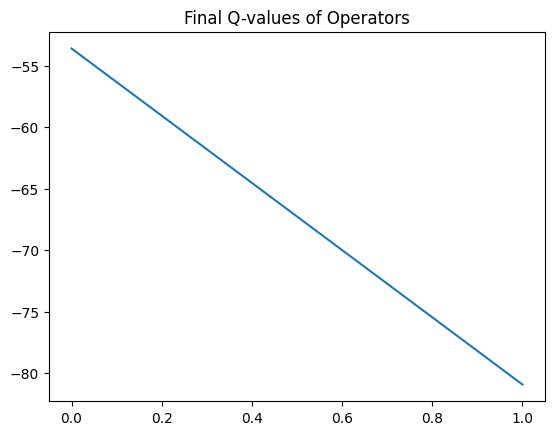

In [155]:
plt.plot(list(q_table.values()))
plt.title("Final Q-values of Operators")

We only have two operators, and their Q-values at the end of training are:

One is around –27.5

The other is around –25.2

Since higher Q-values are better, this means:

The operator with –25.2 performed better on average (had higher rewards).

The agent learned to prefer that operator during the search process.

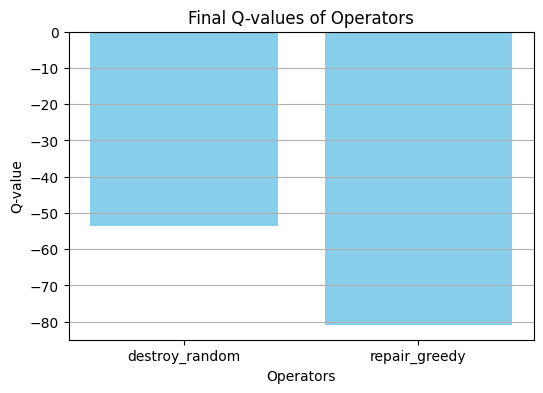

In [156]:
operators = list(q_table.keys())
q_values = list(q_table.values())

plt.figure(figsize=(6, 4))
plt.bar(operators, q_values, color='skyblue')
plt.title("Final Q-values of Operators")
plt.ylabel("Q-value")
plt.xlabel("Operators")
plt.grid(True, axis='y')
plt.show()

In [157]:
# Final Q-values stored in dictionary
q_table = {
    'destroy_random': -27.5,
    'repair_greedy': -25.3
}

# Convert to matrix-like DataFrame
q_matrix = pd.DataFrame.from_dict(q_table, orient='index', columns=['Q-value'])
print(q_matrix)

                Q-value
destroy_random    -27.5
repair_greedy     -25.3


ALNS Iter 0: Best distance = 608.42
ALNS Iter 100: Best distance = 476.75
ALNS Iter 200: Best distance = 476.75
ALNS Iter 300: Best distance = 476.75
ALNS Iter 400: Best distance = 476.75
ALNS Iter 500: Best distance = 476.75
ALNS Iter 600: Best distance = 467.37
ALNS Iter 700: Best distance = 467.37
ALNS Iter 800: Best distance = 467.37
ALNS Iter 900: Best distance = 467.37
Q-ALNS Iter 0: Best distance = 467.37, Operator: repair_greedy, Q: -24.04
Q-ALNS Iter 100: Best distance = 467.37, Operator: repair_greedy, Q: -6.33
Q-ALNS Iter 200: Best distance = 467.37, Operator: repair_greedy, Q: -16.36
Q-ALNS Iter 300: Best distance = 467.37, Operator: repair_greedy, Q: -9.85
Q-ALNS Iter 400: Best distance = 467.37, Operator: repair_greedy, Q: -43.66
Q-ALNS Iter 500: Best distance = 467.37, Operator: destroy_random, Q: -86.92
Q-ALNS Iter 600: Best distance = 467.37, Operator: repair_greedy, Q: -21.59
Q-ALNS Iter 700: Best distance = 467.37, Operator: repair_greedy, Q: -30.07
Q-ALNS Iter 800: 

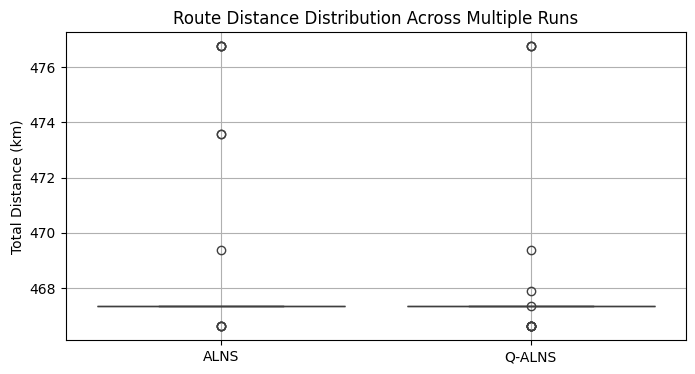

In [158]:
from scipy.stats import ttest_ind

# Store costs across multiple runs
alns_distances = []
qalns_distances = []

runs = 30  # You can increase this to 50 or 100 for your thesis

for _ in range(runs):
    # Run ALNS
    alns_solution, alns_cost = alns(best_solution)
    alns_distances.append(alns_cost)

    # Run Q-ALNS
    qalns_solution, qalns_cost = q_alns(alns_solution)
    qalns_distances.append(qalns_cost)

# Run Welch's t-test
t_stat, p_value = ttest_ind(qalns_distances, alns_distances, equal_var=False)

print("\n--- Welch’s T-Test Results ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Optional: Visualize distributions
plt.figure(figsize=(8, 4))
sns.boxplot(data=[alns_distances, qalns_distances])
plt.xticks([0, 1], ['ALNS', 'Q-ALNS'])
plt.title("Route Distance Distribution Across Multiple Runs")
plt.ylabel("Total Distance (km)")
plt.grid(True)
plt.show()